# LAB 01: Data collection and visualization

### Team information

Class : 22KHDL

|Student's ID| Name |
|------------|--------------|
|22127460| Quách Trần Quán Vinh|
|22127478| Nguyễn Hoàng Trung Kiên|

### Import libraries

- Libraries to handle and visualize data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

- Libraries to collect data

In [ ]:
from requests import get, post
from sys import exit
import os
from dotenv import load_dotenv

## 1. Data collection

### 1.1. Crawling data

In [ ]:
load_dotenv()

HOST = 'https://api.chartmetric.com'
TOKEN = os.getenv('REFRESH_TOKEN')
res = post(f'{HOST}/api/token', json={"refreshtoken": TOKEN})
if res.status_code != 200:
    print(f'ERROR: received a {res.status_code} instead of 200 from /api/token')
    exit(1)

access_token = res.json()['token']
def Get(uri):
    return get(f'{HOST}{uri}', headers={'Authorization': f'Bearer {access_token}'})

tracks = []
for i in range(0, 10000, 100):
    res = Get(f'/api/track/list/filter?limit=100&offset={i}')
    if res.status_code != 200:
        print(f'ERROR: received a {res.status_code} instead of 200 from /api/track/list/filter')
        exit(1)
        
    objs = res.json()['obj']

    for obj in objs:
        track = {
            'id': obj['cm_track'],
            'track_name': obj['name'],
            'album_name': obj['album'][0]['name'],
            'release_date': obj['album'][0]['release_date'],
            'artist': [artist['name'] for artist in obj['artist']],
            'genre': obj['genre'],
            'explicit': obj['explicit'],
            'score': obj['score'],
        }
        
        for key in obj['latest'].keys():
            if key == 'rank':
                continue
            track[key] = obj['latest'][key]
        tracks.append(track)
    
tracks_df = pd.DataFrame(tracks)
tracks_df.to_csv('tracks_chartmetric.csv', index=False)

### 1.2. Exploring and preprocessing data

#### 1.2.1. Data exploration

- Read data 

In [2]:
df = pd.read_csv('tracks_chartmetric.csv')
df

,id,track_name,album_name,release_date,artist,genre,explicit,score,airplay_streams,amazon_playlist_count,...,spotify_popularity,spotify_ed_playlist_count,spotify_ed_playlist_total_reach,tidal_popularity,tiktok_posts,tiktok_top_videos_likes,tiktok_top_videos_views,youtube_likes,youtube_playlist_count,youtube_views
0,138071658,APT.,APT.,2024-10-18,"['ROSÉ', 'Bruno Mars']","['Pop', 'K-Pop', 'Dance']",False,0.966846,336709.0,NaN,...,92.0,164.0,109435710.0,NaN,9058000.0,938397392.0,1.256294e+10,14266985.0,373.0,1.180584e+09
1,134780977,Die With A Smile,Die With A Smile,2024-08-16,"['Lady Gaga', 'Bruno Mars']",['Pop'],False,0.588069,466036.0,145.0,...,97.0,187.0,105551916.0,NaN,2600000.0,595192902.0,4.572196e+09,843476.0,2.0,4.126108e+07
2,120611262,BIRDS OF A FEATHER,HIT ME HARD AND SOFT,2024-05-17,['Billie Eilish'],"['Pop', 'Alternative', 'Alternative Rock']",True,0.499970,670692.0,142.0,...,95.0,208.0,112169955.0,NaN,1500000.0,522050067.0,4.114507e+09,6220211.0,262.0,5.426091e+08
3,118981138,Espresso,Espresso,2024-04-12,['Sabrina Carpenter'],['Pop'],True,0.455367,938885.0,186.0,...,85.0,188.0,42425762.0,NaN,928200.0,312540065.0,2.890147e+09,5964770.0,243.0,6.682628e+08
4,120189440,Not Like Us,Not Like Us,2024-05-04,['Kendrick Lamar'],['Hip-Hop/Rap'],True,0.448599,416457.0,171.0,...,93.0,150.0,68921402.0,NaN,2900000.0,420232035.0,3.423082e+09,12687671.0,278.0,6.773596e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,142018026,Un Dolor,Tesoros de Colección,2024-11-27,"[""Los Yonic's""]",['Others'],False,0.012359,NaN,NaN,...,8.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,17469970,Wait,Wait,2017-10-31,['Maroon 5'],['Pop'],False,0.012366,17989.0,12.0,...,57.0,15.0,1991.0,NaN,1766.0,251574.0,3.703557e+06,1588524.0,10.0,2.174645e+08
9997,96743526,Niagara Falls (Foot or 2) [with Travis Scott &...,HEROES & VILLAINS,2022-12-02,"['Metro Boomin', 'Travis Scott', '21 Savage']",['Hip-Hop/Rap'],False,0.012430,217.0,NaN,...,41.0,0.0,0.0,NaN,NaN,NaN,NaN,224742.0,NaN,2.621794e+07
9998,15674336,We R Who We R,We R Who We R,2010-10-26,['Kesha'],"['Hip-Hop/Rap', 'Pop', 'Electronic']",False,0.012362,8480.0,4.0,...,69.0,18.0,1630423.0,NaN,172954.0,49939590.0,3.771906e+08,1083666.0,10.0,2.178190e+08


- Data information

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               10000 non-null  int64  
 1   track_name                       10000 non-null  object 
 2   album_name                       9999 non-null   object 
 3   release_date                     10000 non-null  object 
 4   artist                           10000 non-null  object 
 5   genre                            10000 non-null  object 
 6   explicit                         9775 non-null   object 
 7   score                            10000 non-null  float64
 8   airplay_streams                  8366 non-null   float64
 9   amazon_playlist_count            6898 non-null   float64
 10  deezer_playlist_count            7276 non-null   float64
 11  itunes_playlist_count            8434 non-null   float64
 12  shazam_count       

There are 1 ```int``` type column, 6 ```object``` type columns and 21 ```float``` type columns.

In [4]:
df.shape

(10000, 28)

The raw data contains 10000 rows and 28 columns

- Data columns

In [5]:
print(df.columns)

Index(['id', 'track_name', 'album_name', 'release_date', 'artist', 'genre',
       'explicit', 'score', 'airplay_streams', 'amazon_playlist_count',
       'deezer_playlist_count', 'itunes_playlist_count', 'shazam_count',
       'siriusxm_streams', 'soundcloud_plays', 'spotify_playlist_count',
       'spotify_playlist_total_reach', 'spotify_plays', 'spotify_popularity',
       'spotify_ed_playlist_count', 'spotify_ed_playlist_total_reach',
       'tidal_popularity', 'tiktok_posts', 'tiktok_top_videos_likes',
       'tiktok_top_videos_views', 'youtube_likes', 'youtube_playlist_count',
       'youtube_views'],
      dtype='object')


**Meaning of each columns**

| Column Name                         | Description |
|--------------------------------------|-------------|
| `id`                                 | Track's identifier |
| `track_name`                         | Name of the track |
| `album_name`                         | Name of the album the track belongs to |
| `release_date`                       | Track's release date |
| `artist`                             | Name of the artist of the track |
| `genre`                              | Track's genre |
| `explicit`                           | Indicates whether the track has explicit content (`True/False`) |
| `score`                              | Overall rating score of the track |
| `airplay_streams`                    | Number of times the track was streamed on radio platforms |
| `amazon_playlist_count`              | Number of Amazon Music playlists featuring the track |
| `deezer_playlist_count`              | Number of Deezer playlists featuring the track |
| `itunes_playlist_count`              | Number of Apple Music (iTunes) playlists featuring the track |
| `shazam_count`                       | Number of times the track was identified on Shazam |
| `siriusxm_streams`                   | Number of streams from SiriusXM radio |
| `soundcloud_plays`                   | Number of plays on SoundCloud |
| `spotify_playlist_count`             | Number of Spotify playlists featuring the track |
| `spotify_playlist_total_reach`       | Total reach (followers) of all Spotify playlists containing the track |
| `spotify_plays`                      | Number of times the track was played on Spotify |
| `spotify_popularity`                 | Popularity score of the track on Spotify |
| `spotify_ed_playlist_count`          | Number of Spotify editorial playlists featuring the track |
| `spotify_ed_playlist_total_reach`    | Total reach (followers) of all Spotify editorial playlists containing the track |
| `tidal_popularity`                   | Popularity score of the track on Tidal |
| `tiktok_posts`                       | Number of TikTok posts using the track |
| `tiktok_top_videos_likes`            | Total likes of the top TikTok videos using the track |
| `tiktok_top_videos_views`            | Total views of the top TikTok videos using the track |
| `youtube_likes`                      | Total number of likes on YouTube videos featuring the track |
| `youtube_playlist_count`             | Number of YouTube playlists containing the track |
| `youtube_views`                      | Total views of the track on YouTube |



#### 1.2.2. Data preprocessing

- Handle duplicates

In [6]:
df.duplicated().sum()

np.int64(29)

There are 29 duplicate records in the data so we will drop them.

In [7]:
df = df.drop_duplicates()

- Handle missing values

In [8]:
df.isna().sum()

id                                    0
track_name                            0
album_name                            1
release_date                          0
artist                                0
genre                                 0
explicit                            224
score                                 0
airplay_streams                    1629
amazon_playlist_count              3092
deezer_playlist_count              2717
itunes_playlist_count              1563
shazam_count                       1857
siriusxm_streams                   5635
soundcloud_plays                   7557
spotify_playlist_count              170
spotify_playlist_total_reach        170
spotify_plays                       216
spotify_popularity                  460
spotify_ed_playlist_count           170
spotify_ed_playlist_total_reach     170
tidal_popularity                   9971
tiktok_posts                       2037
tiktok_top_videos_likes            2804
tiktok_top_videos_views            2805


There are some columns which have high quantity of missing records. We will drop the columns that have over 2000 missing values.

In [9]:
df = df.drop(columns=['amazon_playlist_count', 'deezer_playlist_count', 'siriusxm_streams', 
                      'soundcloud_plays', 'tidal_popularity', 'tiktok_posts', 'tiktok_top_videos_likes', 
                      'tiktok_top_videos_views', 'youtube_playlist_count'])

Column ```id``` is not really meaningful for further analysis so we will remove it as well.

In [10]:
df = df.drop(columns='id')

For categorical columns, there are 2 columns that have missing values. They are ```album_name``` and ```explicit```. ```Explicit``` can be filled by **mode** since it only contains 1 of 2 values true/false. However, ```album_name``` cannot be determined by mode because it will not be true and reliable based on the data's domain knowledge which misrepresents the data. So the row with missing value in ```album_name``` column will be eliminated.

In [11]:
df = df.dropna(subset=['album_name']).copy()  
df['explicit'] = df['explicit'].astype(str)
mode_value = df['explicit'].mode()[0]
df['explicit'] = df['explicit'].fillna(mode_value).map(lambda x: str(x).lower() == 'true')

We will check the distribution of each numeric columns to decide which method of handling missing values would be approriate. (**Note:** This visualization is just a step to decide filling missing values method, not the main part of visualization of this Project.)

- Define numeric columns

In [12]:
numeric_cols = ['score', 'airplay_streams', 'itunes_playlist_count', 'shazam_count', 'spotify_playlist_count'	
                ,'spotify_playlist_total_reach', 'spotify_plays', 'spotify_popularity', 'spotify_ed_playlist_count',
                'spotify_ed_playlist_total_reach', 'youtube_likes', 'youtube_views']

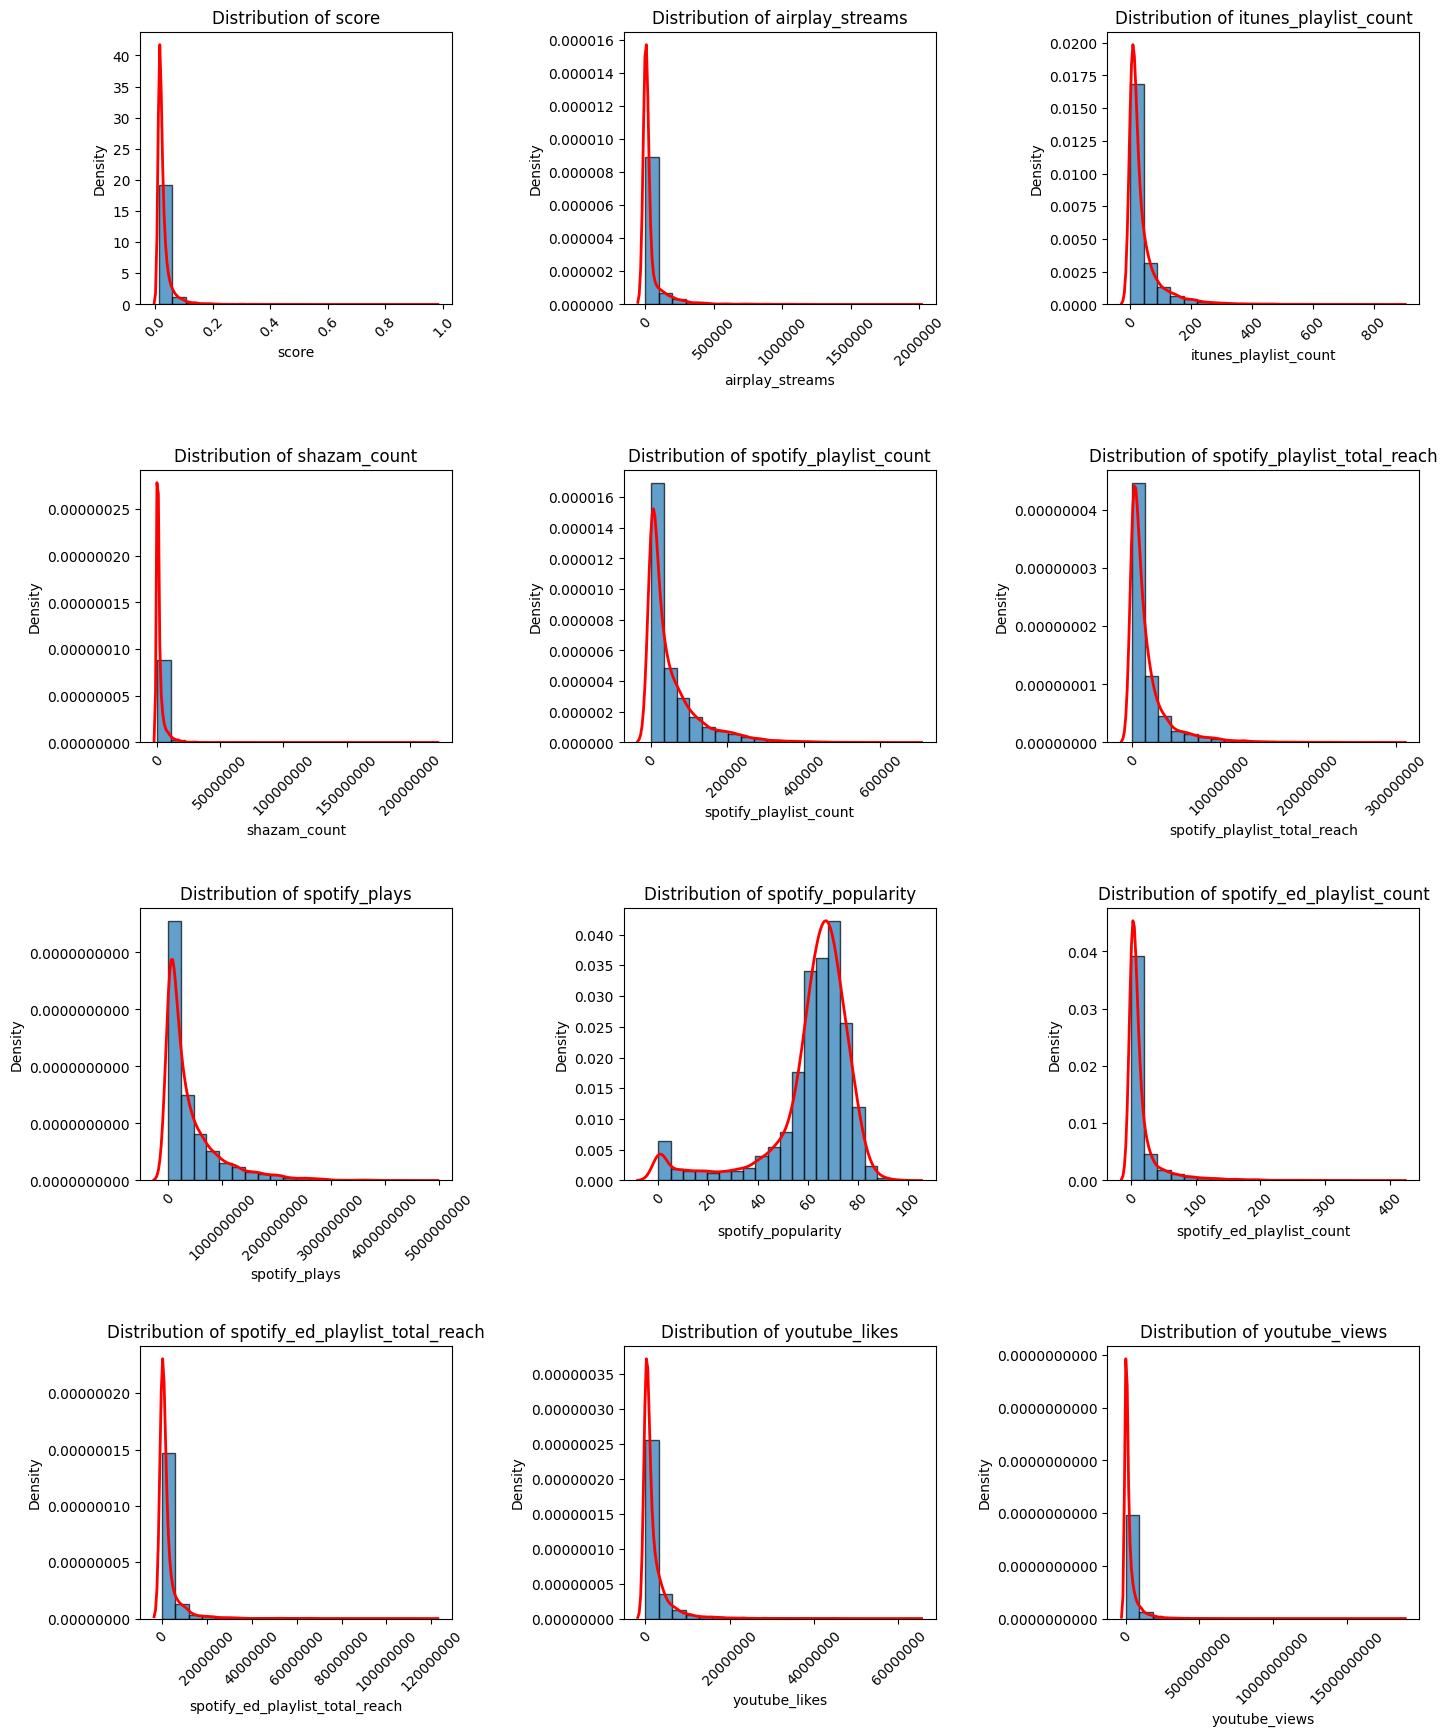

In [13]:
plt.figure(figsize=(15, 18))  

for i in range(len(numeric_cols)):
    plt.subplot(4, 3, i + 1)
    plt.hist(df[numeric_cols[i]], bins=20, edgecolor='black', alpha=0.7, density=True)
    sns.kdeplot(df[numeric_cols[i]], color='red', linewidth=2)
    plt.title(f'Distribution of {numeric_cols[i]}')
    plt.xlabel(numeric_cols[i])
    plt.ylabel('Density')
    plt.xticks(rotation=45)
    plt.ticklabel_format(style='plain', axis='both')  
    
plt.tight_layout(pad=3.0)
plt.show()

From the plot above we can see that the numeric columns have heavily right-skewed distribution because of some outliers.

$\rightarrow$ To handle this we will fill missing values with **median** for simplicity since the columns have low number of missing values so use this filling method will not effect the distribution.

In [14]:
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

- Check missing values again

In [15]:
df.isna().sum()

track_name                         0
album_name                         0
release_date                       0
artist                             0
genre                              0
explicit                           0
score                              0
airplay_streams                    0
itunes_playlist_count              0
shazam_count                       0
spotify_playlist_count             0
spotify_playlist_total_reach       0
spotify_plays                      0
spotify_popularity                 0
spotify_ed_playlist_count          0
spotify_ed_playlist_total_reach    0
youtube_likes                      0
youtube_views                      0
dtype: int64

The data now has no missing values.

- Handle data format

We take a look through the data types.

In [16]:
df.dtypes

track_name                          object
album_name                          object
release_date                        object
artist                              object
genre                               object
explicit                              bool
score                              float64
airplay_streams                    float64
itunes_playlist_count              float64
shazam_count                       float64
spotify_playlist_count             float64
spotify_playlist_total_reach       float64
spotify_plays                      float64
spotify_popularity                 float64
spotify_ed_playlist_count          float64
spotify_ed_playlist_total_reach    float64
youtube_likes                      float64
youtube_views                      float64
dtype: object

All columns that has ```float``` type (except ```score```) should be converted into ```int``` type since they represent count, likes, views, etc.

In [17]:
columns = [
    'airplay_streams',                  
    'itunes_playlist_count',            
    'shazam_count',                      
    'spotify_playlist_count',  
    'spotify_playlist_total_reach',  
    'spotify_plays',        
    'spotify_popularity',
    'spotify_ed_playlist_count',   
    'spotify_ed_playlist_total_reach',     
    'youtube_likes',                    
    'youtube_views'
]

In [18]:
df[columns] = df[columns].astype(int)

```release_date``` column should have ```datetime``` type.

In [19]:
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

Check data type again.

In [20]:
df.dtypes

track_name                                 object
album_name                                 object
release_date                       datetime64[ns]
artist                                     object
genre                                      object
explicit                                     bool
score                                     float64
airplay_streams                             int64
itunes_playlist_count                       int64
shazam_count                                int64
spotify_playlist_count                      int64
spotify_playlist_total_reach                int64
spotify_plays                               int64
spotify_popularity                          int64
spotify_ed_playlist_count                   int64
spotify_ed_playlist_total_reach             int64
youtube_likes                               int64
youtube_views                               int64
dtype: object

The columns now have correct types.

The columns ```artist``` and ```genre``` stores value as list, but the data treated them as string type, for ease use, we will remove the characters ```[]``` and ```''``` in them.

In [21]:
df['artist'] = df['artist'].str.replace(r"[\[\]']", "", regex=True)
df['genre'] = df['genre'].str.replace(r"[\[\]']", "", regex=True)

### Data after being preprocessed

In [22]:
df

,track_name,album_name,release_date,artist,genre,explicit,score,airplay_streams,itunes_playlist_count,shazam_count,spotify_playlist_count,spotify_playlist_total_reach,spotify_plays,spotify_popularity,spotify_ed_playlist_count,spotify_ed_playlist_total_reach,youtube_likes,youtube_views
0,APT.,APT.,2024-10-18,"ROSÉ, Bruno Mars","Pop, K-Pop, Dance",False,0.966846,336709,9,574324,90419,274203572,1222630989,92,164,109435710,14266985,1180584071
1,Die With A Smile,Die With A Smile,2024-08-16,"Lady Gaga, Bruno Mars",Pop,False,0.588069,466036,348,10242973,180800,278012420,1938870521,97,187,105551916,843476,41261078
2,BIRDS OF A FEATHER,HIT ME HARD AND SOFT,2024-05-17,Billie Eilish,"Pop, Alternative, Alternative Rock",True,0.499970,670692,404,7881055,195827,298624666,2126764510,95,208,112169955,6220211,542609125
3,Espresso,Espresso,2024-04-12,Sabrina Carpenter,Pop,True,0.455367,938885,314,5698679,188214,215527109,1977140175,85,188,42425762,5964770,668262835
4,Not Like Us,Not Like Us,2024-05-04,Kendrick Lamar,Hip-Hop/Rap,True,0.448599,416457,336,6001425,236267,202931595,1201295523,93,150,68921402,12687671,677359643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Un Dolor,Tesoros de Colección,2024-11-27,"""Los Yonics""",Others,False,0.012359,3197,18,574324,2,13,53644383,8,0,0,718399,86105878
9996,Wait,Wait,2017-10-31,Maroon 5,Pop,False,0.012366,17989,39,2850478,30772,12576658,447237443,57,15,1991,1588524,217464542
9997,Niagara Falls (Foot or 2) [with Travis Scott &...,HEROES & VILLAINS,2022-12-02,"Metro Boomin, Travis Scott, 21 Savage",Hip-Hop/Rap,False,0.012430,217,2,574324,6096,610413,389049561,41,0,0,224742,26217944
9998,We R Who We R,We R Who We R,2010-10-26,Kesha,"Hip-Hop/Rap, Pop, Electronic",False,0.012362,8480,83,1743329,69065,33843487,347936667,69,18,1630423,1083666,217819011


Store data into csv.

In [23]:
df.to_csv('tracks_preprocessed.csv')

## 2. Data visualization

### 2.1. Data introduction

#### 2.1.1. Introduction

#### 2.1.2. Sample size

In [24]:
df.shape

(9970, 18)

The data now has 9970 rows (> 3000 rows) with meaningful columns suitable for analysis.

#### 2.1.3. Structures

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9970 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   track_name                       9970 non-null   object        
 1   album_name                       9970 non-null   object        
 2   release_date                     9970 non-null   datetime64[ns]
 3   artist                           9970 non-null   object        
 4   genre                            9970 non-null   object        
 5   explicit                         9970 non-null   bool          
 6   score                            9970 non-null   float64       
 7   airplay_streams                  9970 non-null   int64         
 8   itunes_playlist_count            9970 non-null   int64         
 9   shazam_count                     9970 non-null   int64         
 10  spotify_playlist_count           9970 non-null   int64         
 

#### 2.1.4. Statistics description

In [26]:
df[numeric_cols].describe()

,score,airplay_streams,itunes_playlist_count,shazam_count,spotify_playlist_count,spotify_playlist_total_reach,spotify_plays,spotify_popularity,spotify_ed_playlist_count,spotify_ed_playlist_total_reach,youtube_likes,youtube_views
count,9970.000000,9.970000e+03,9970.000000,9.970000e+03,9970.000000,9.970000e+03,9.970000e+03,9970.000000,9970.000000,9.970000e+03,9.970000e+03,9.970000e+03
mean,0.029962,3.536284e+04,36.809328,1.725359e+06,51965.127482,1.665450e+07,4.059216e+08,61.357071,16.120963,2.721139e+06,1.822432e+06,2.545591e+08
std,0.032211,1.027143e+05,55.493781,4.312284e+06,70388.260864,2.451138e+07,5.315570e+08,16.863358,30.313205,7.120823e+06,3.374848e+06,5.250900e+08
min,0.012359,1.000000e+00,1.000000,1.000000e+00,1.000000,0.000000e+00,1.066000e+03,0.000000,0.000000,0.000000e+00,0.000000e+00,2.000000e+00
25%,0.015237,4.507500e+02,8.000000,2.290188e+05,4924.000000,2.611963e+06,6.057779e+07,59.000000,2.000000,1.506650e+04,2.432945e+05,2.613770e+07
50%,0.020243,3.197000e+03,18.000000,5.743240e+05,24257.000000,8.233730e+06,2.029017e+08,65.000000,6.000000,5.784450e+05,7.183990e+05,8.610588e+07
75%,0.031386,1.762950e+04,39.000000,1.460020e+06,70820.750000,1.990739e+07,5.333236e+08,71.000000,15.000000,2.382945e+06,1.922136e+06,2.465413e+08
max,0.966846,1.962831e+06,875.000000,2.197945e+08,673695.000000,2.986247e+08,4.723352e+09,97.000000,409.000000,1.194549e+08,6.371121e+07,1.871716e+10


### 2.2. Data analysis and visualization objectives

There are 2 members in our team, so we decide to derive 4 objectives:

#### 1. How do popular Pop tracks reach their audience on Spotify from 2020 to 2024?

**Benefits**
- Helps the artists and producers release tracks that can increase their engagement, keep up with the trends and reach a wider audience. 

- Enhances playlists, keeps listeners engaged, and recommends the best mix of Pop songs.

**Features used in data**

- ```release_date```, ```genre```, ```spotify_playlist_count```, ```spotify_playlist_total_reach```, ```spotify_plays```, ```spotify_popularity```

#### 2. What are the seasonal trends of high-scoring tracks on YouTube?

**Benefits**
- Helps the artists, producers or content creators make strategies to release trending tracks, from that maximizing views and likes count on Youtube platform.

- Viewers can discover the best music videos or playlists for every seasons.

**Features used in data**

- ```track_name```, ```score```, ```release date```, ```youtube_likes```, ```youtube_views```

#### 3. Who are the top 10 artists with the highest Spotify popularity, and how do they engage audiences across platforms?

**Benefits**
- Provides insights for artists, music producers to review their current work and make some useful strategies for the future plans.

- Helps to understand if the successful artists made huge influence across different platforms.

- Enhances playlist filter by featuring artists with strong cross-platform influence.

**Features used in data**

#### 4. Does the effect of explicit content vary by genre? (e.g., Hip-Hop vs. Pop vs. Rock)

**Benefits**
- Helps artists and composers alter the lyrics which is suitable for the audience expectation for maximum reach and engagement.

- Reveals audience preferences for explicit vs. clean content across different genres whether they prefer the tracks that have explicit content or not.

**Features used in data**
- ```genre```, ```explicit```, ```score```, ```spotify_popularity```

### 2.3. Data visualization